Importing Libraries

In [1]:
import os
import numpy as np
import librosa
import librosa.display
import soundfile as sf
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

Setting Datapaths

In [3]:
DATASET_ROOT = "./LA/LA"
TRAIN_FOLDER = os.path.join(DATASET_ROOT, "ASVspoof2019_LA_train")
DEV_FOLDER = os.path.join(DATASET_ROOT, "ASVspoof2019_LA_dev")
PROTOCOL_FILE = os.path.join(DATASET_ROOT, "ASVspoof2019_LA_cm_protocols", "ASVspoof2019.LA.cm.train.trn.txt")

Loading Dataset

In [2]:
def load_dataset(folder, protocol_file):
    features, labels = [], []
    with open(protocol_file, 'r') as f:
        for line in f:
            parts = line.strip().split()
            file_name, label = parts[1], parts[-1]
            file_path = os.path.join(folder, "flac", file_name + ".flac")
            if os.path.exists(file_path):
                features.append(extract_features(file_path))
                labels.append(label)
    return np.array(features), np.array(labels)

Extracting Features

In [4]:
def extract_features(file_path, n_mfcc=20):
    y, sr = librosa.load(file_path, sr=16000)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    return np.mean(mfccs, axis=1)  # Use mean of MFCCs over time

Loading Train Data

In [7]:
X_train, y_train = load_dataset(TRAIN_FOLDER, PROTOCOL_FILE)

Plotting Class Distribution

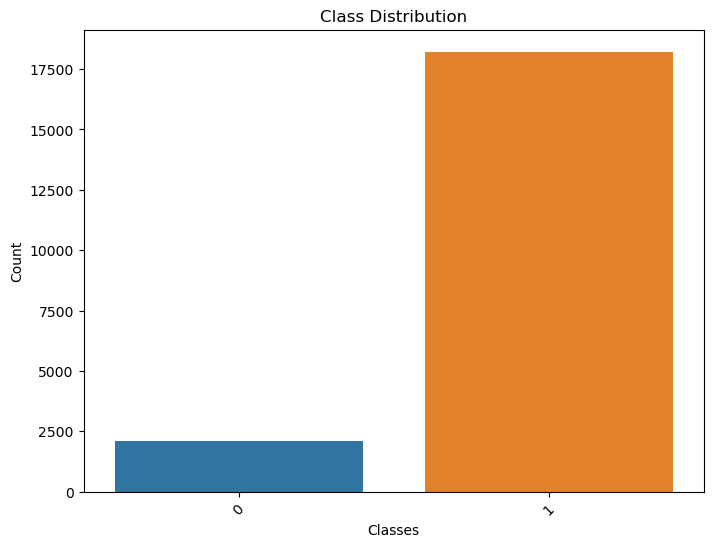

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Class Distribution
plt.figure(figsize=(8, 6))
sns.countplot(x=y_train)
plt.title("Class Distribution")
plt.xlabel("Classes")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

Plotting Feature Distribution

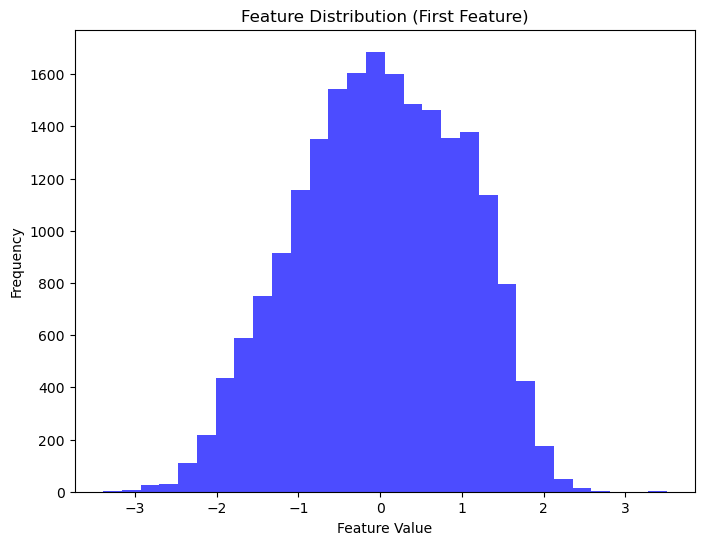

In [25]:
# Feature Distribution
plt.figure(figsize=(8, 6))
plt.hist(X_train[:, 0], bins=30, color='blue', alpha=0.7)
plt.title("Feature Distribution (First Feature)")
plt.xlabel("Feature Value")
plt.ylabel("Frequency")
plt.show()

Visualising a Single Sample

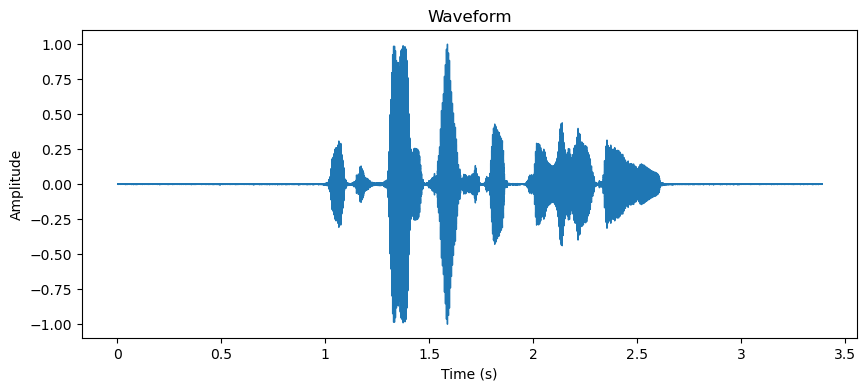

In [26]:
sample_file = r'LA\LA\ASVspoof2019_LA_train\flac\LA_T_1003665.flac'  # Example File
audio, sr = librosa.load(sample_file, sr=None)

# Plot Waveform
plt.figure(figsize=(10, 4))
librosa.display.waveshow(audio, sr=sr)
plt.title("Waveform")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

Plotting MEL Spectogram

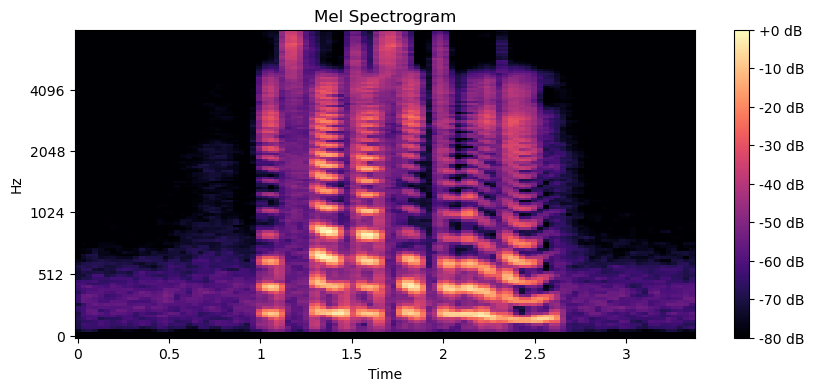

In [27]:
# Plot Spectrogram
plt.figure(figsize=(10, 4))
spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr)
librosa.display.specshow(librosa.power_to_db(spectrogram, ref=np.max), sr=sr, x_axis='time', y_axis='mel')
plt.title("Mel Spectrogram")
plt.colorbar(format='%+2.0f dB')
plt.show()

Label Encoding

In [8]:
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)

Normalising Features

In [9]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

Splitting into Train & Test

In [10]:
# Split dataset
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

Training on SVM Classifier

In [15]:
svm = SVC(C=10, gamma='auto', kernel='rbf', degree=2)
svm.fit(X_train, y_train)

SVC(C=10, degree=2, gamma='auto')

Plotting the Feature Vector

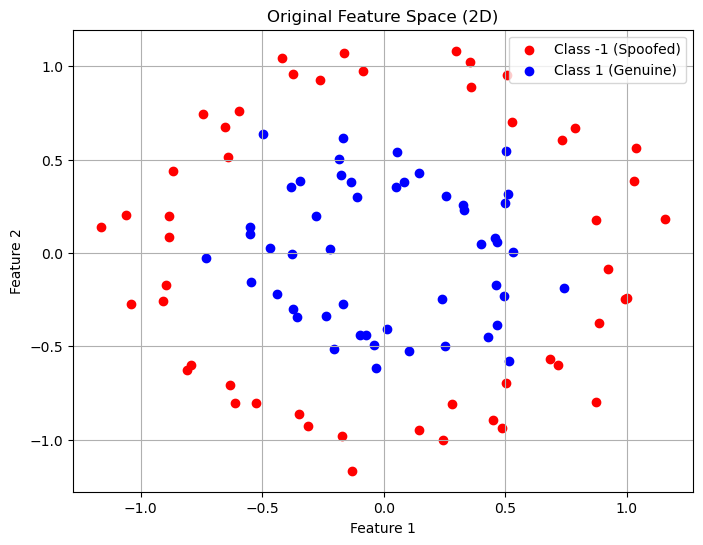

In [19]:
from sklearn.datasets import make_circles
from mpl_toolkits.mplot3d import Axes3D

# Generate synthetic data (e.g., genuine vs. spoofed speech)
X, y = make_circles(n_samples=100, factor=0.5, noise=0.1, random_state=42)
y = 2 * y - 1  # Convert labels to -1 and 1 for SVM

# Plot the original 2D data
plt.figure(figsize=(8, 6))
plt.scatter(X[y == -1, 0], X[y == -1, 1], color='red', label='Class -1 (Spoofed)')
plt.scatter(X[y == 1, 0], X[y == 1, 1], color='blue', label='Class 1 (Genuine)')
plt.title("Original Feature Space (2D)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.grid(True)
plt.show()

Plot of RBF Kernel Transformation

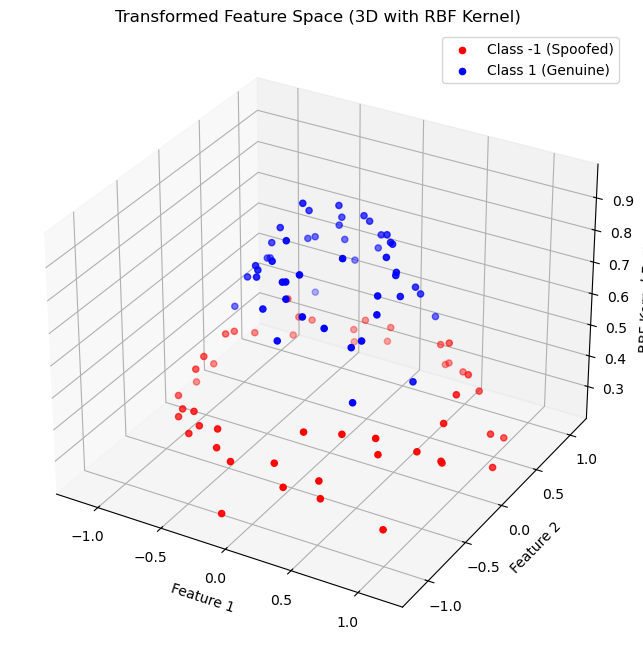

In [20]:
# Apply RBF kernel transformation (conceptual 3D visualization)
def rbf_kernel_3d(X, gamma=1.0):
    """Apply a conceptual RBF kernel transformation to 3D."""
    return np.exp(-gamma * (X[:, 0]**2 + X[:, 1]**2))

Z = rbf_kernel_3d(X)

# Plot the transformed feature space in 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[y == -1, 0], X[y == -1, 1], Z[y == -1], color='red', label='Class -1 (Spoofed)')
ax.scatter(X[y == 1, 0], X[y == 1, 1], Z[y == 1], color='blue', label='Class 1 (Genuine)')
ax.set_title("Transformed Feature Space (3D with RBF Kernel)")
ax.set_xlabel("Feature 1")
ax.set_ylabel("Feature 2")
ax.set_zlabel("RBF Kernel Feature")
ax.legend()
plt.show()

Plot of SVM Decision Boundary

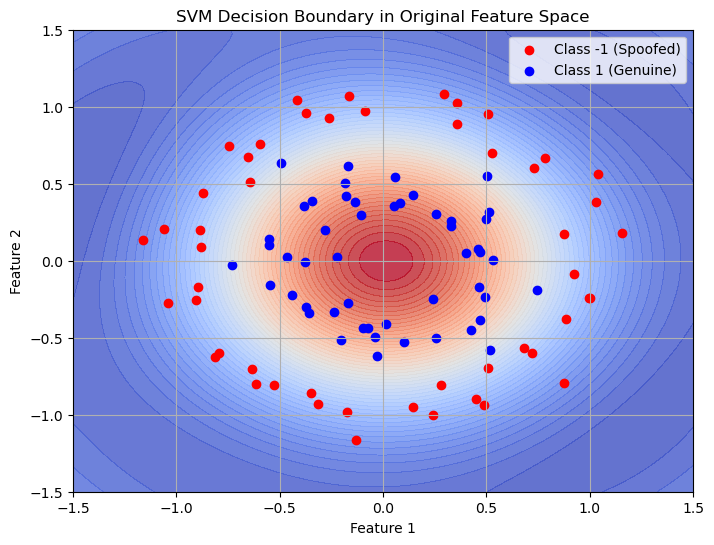

In [21]:
# Plot the decision boundary in the original 2D space
xx, yy = np.meshgrid(np.linspace(-1.5, 1.5, 100), np.linspace(-1.5, 1.5, 100))
Z = svm.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), Z.max(), 50), cmap=plt.cm.coolwarm, alpha=0.8)
plt.scatter(X[y == -1, 0], X[y == -1, 1], color='red', label='Class -1 (Spoofed)')
plt.scatter(X[y == 1, 0], X[y == 1, 1], color='blue', label='Class 1 (Genuine)')
plt.title("SVM Decision Boundary in Original Feature Space")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.grid(True)
plt.show()

Evaluating Model

In [12]:
y_pred = svm.predict(X_val)
print("Accuracy:", accuracy_score(y_val, y_pred))
print(classification_report(y_val, y_pred, target_names=label_encoder.classes_))


Accuracy: 0.9806934594168637
              precision    recall  f1-score   support

    bonafide       0.95      0.85      0.90       505
       spoof       0.98      0.99      0.99      4571

    accuracy                           0.98      5076
   macro avg       0.97      0.92      0.94      5076
weighted avg       0.98      0.98      0.98      5076



Grid-Search CV

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly'], 
    'gamma': ['scale', 'auto'],  
    'degree': [2, 3, 4]
}


svm = SVC()

grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)

grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_val)

from sklearn.metrics import accuracy_score, classification_report
print("Accuracy on Validation Set:", accuracy_score(y_val, y_pred))
print(classification_report(y_val, y_pred, target_names=label_encoder.classes_))

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best Parameters: {'C': 10, 'degree': 2, 'gamma': 'auto', 'kernel': 'rbf'}
Best Cross-Validation Accuracy: 0.9837469477172623
Accuracy on Validation Set: 0.9887706855791962
              precision    recall  f1-score   support

    bonafide       0.95      0.93      0.94       505
       spoof       0.99      0.99      0.99      4571

    accuracy                           0.99      5076
   macro avg       0.97      0.96      0.97      5076
weighted avg       0.99      0.99      0.99      5076



Calculating Performance Metric like EER, DET Curve

Equal Error Rate (EER): 0.0653
EER Threshold: 1.0000


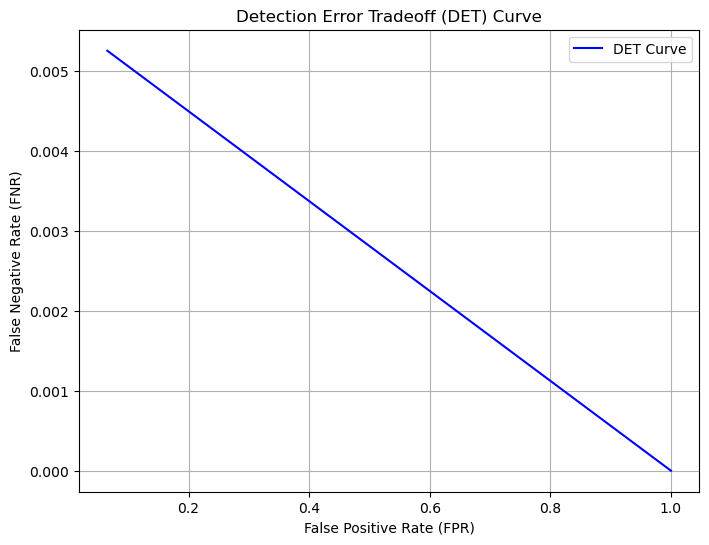

In [35]:
import numpy as np
from sklearn.metrics import roc_curve, det_curve
import matplotlib.pyplot as plt

def calculate_eer(y_true, y_scores):
    """
    Calculate Equal Error Rate (EER).
    :param y_true: Ground truth labels (0 for negative, 1 for positive).
    :param y_scores: Predicted scores or probabilities for the positive class.
    :return: EER value and the threshold at which it occurs.
    """
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    fnr = 1 - tpr  # False Negative Rate

    # Find the point where FPR and FNR are closest
    eer_threshold = thresholds[np.nanargmin(np.abs(fpr - fnr))]
    eer = fpr[np.nanargmin(np.abs(fpr - fnr))]

    return eer, eer_threshold

def plot_det_curve(y_true, y_scores):
    """
    Plot the Detection Error Tradeoff (DET) Curve.
    :param y_true: Ground truth labels (0 for negative, 1 for positive).
    :param y_scores: Predicted scores or probabilities for the positive class.
    """
    fpr, fnr, _ = det_curve(y_true, y_scores)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, fnr, label="DET Curve", color="blue")
    plt.title("Detection Error Tradeoff (DET) Curve")
    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("False Negative Rate (FNR)")
    plt.grid(True)
    plt.legend()
    plt.show()

# Example Usage
# y_test: Ground truth labels (binary: 0 or 1)
# y_pred: Predicted probabilities or scores for the positive class

# Ensure y_pred contains probabilities or scores, not binary predictions
# If y_pred is binary, convert it to probabilities using a classifier's `predict_proba` method

# Calculate EER
eer, eer_threshold = calculate_eer(y_val, y_pred)
print(f"Equal Error Rate (EER): {eer:.4f}")
print(f"EER Threshold: {eer_threshold:.4f}")

# Plot DET Curve
plot_det_curve(y_val, y_pred)

Plotting ROC curve & AUC

AUC Score: 0.9241


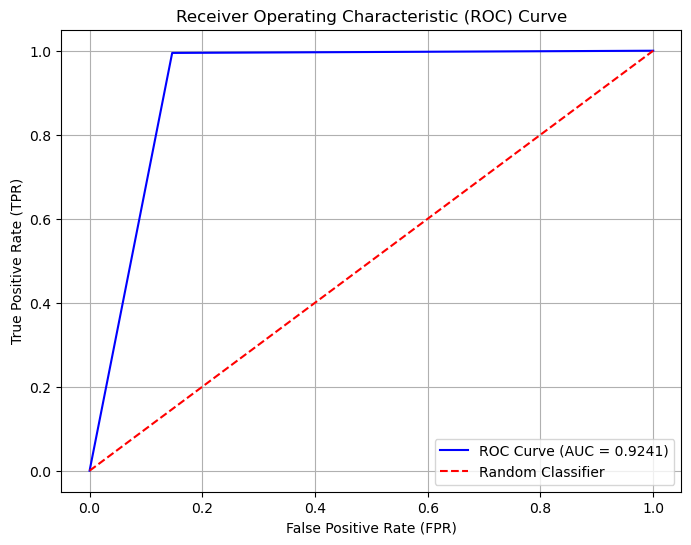

In [18]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Assuming y_test contains the true labels and y_pred contains the predicted probabilities
# Ensure y_pred contains probabilities for the positive class (not binary predictions)

# Calculate the ROC Curve
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

# Calculate the AUC Score
auc_score = roc_auc_score(y_val, y_pred)
print(f"AUC Score: {auc_score:.4f}")

# Plot the ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f"ROC Curve (AUC = {auc_score:.4f})")
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label="Random Classifier")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.legend()
plt.grid(True)

Plotting Results

Plotting Confusion Matrix

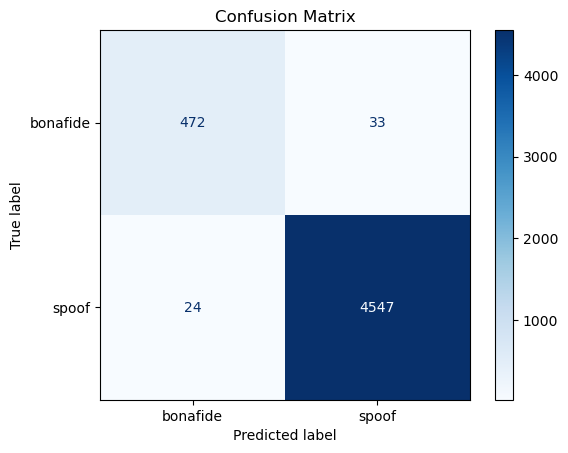

In [29]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Confusion Matrix
conf_matrix = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

Bar Plot for Precision, Recall, and F1-Score

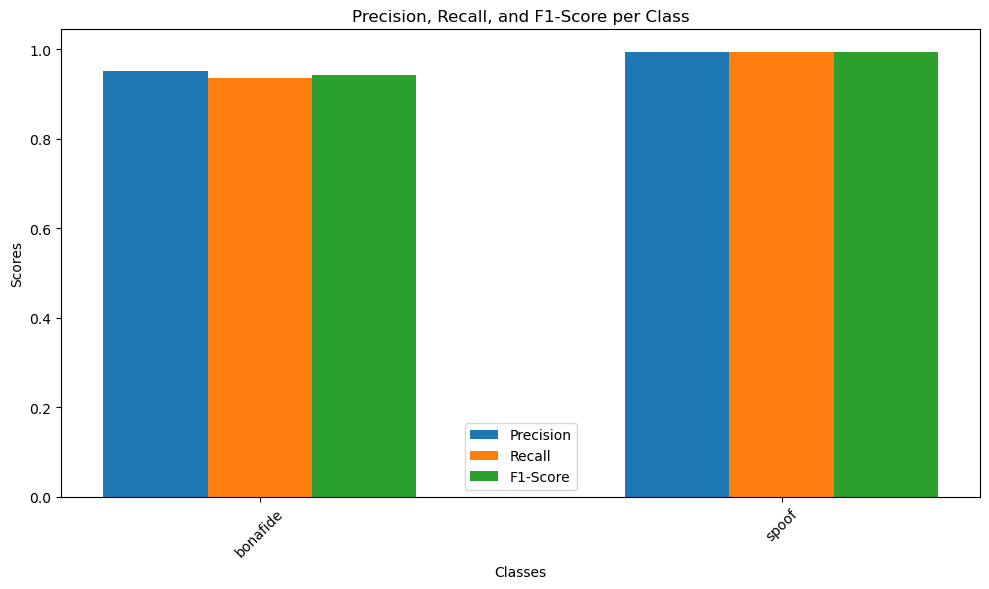

In [31]:
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1_score, _ = precision_recall_fscore_support(y_val, y_pred, average=None)
x_labels = label_encoder.classes_

x = range(len(x_labels))
plt.figure(figsize=(10, 6))
plt.bar(x, precision, width=0.2, label='Precision', align='center')
plt.bar([p + 0.2 for p in x], recall, width=0.2, label='Recall', align='center')
plt.bar([p + 0.4 for p in x], f1_score, width=0.2, label='F1-Score', align='center')
plt.xticks([p + 0.2 for p in x], x_labels, rotation=45)
plt.xlabel("Classes")
plt.ylabel("Scores")
plt.title("Precision, Recall, and F1-Score per Class")
plt.legend()
plt.tight_layout()
plt.show()